# Calculate the barotropic stream function on the ORCA grid

## Preamble: Import modules, turn off warnings, etc.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
from dask.distributed import Client, wait
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr

## Load the whole model run including the mesh file into a single grid-aware data set

In [3]:
data_path = Path("../example-data/ORCA05.L46-KKG36F25H/")

In [4]:
data_files = (
    sorted(data_path.glob("ORCA05.L46-KKG36F25H_1m_20090101_20091231_grid_[U,V].nc")) +
    [data_path / "mesh_mask.nc", data_path / "new_maskglo.nc"]
)

In [5]:
from xorca.lib import preprocess_orca

ds = xr.open_mfdataset(data_files,
                       preprocess=(lambda ds:
                                   preprocess_orca(data_path / "mesh_mask.nc", ds)))
ds = ds.chunk({"t": 1})
ds

<xarray.Dataset>
Dimensions:   (t: 12, x_c: 720, x_r: 720, y_c: 509, y_r: 509, z_c: 46, z_l: 46)
Coordinates:
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * x_r       (x_r) float64 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
  * z_l       (z_l) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 ...
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * y_r       (y_r) float64 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    llat_rr   (y_r, x_r) float32 dask.array<shape=(509, 720), chunksize=(509, 720)>
    depth_l   (z_l) float64 dask.array<shape=(46,), chunksize=(46,)>
    llat_cr   (y_c, x_r) float32 dask.array<shape=(509, 720), chunksize=(509, 720)>
    llon_cr   (y_c, x_r) float32 dask.array<shape=(509, 720), chunksize=(509, 720)>
    llon_cc   (y_c, x_c) float32 dask.array<shape=(509, 720), chunksize=(509, 720)>
    llon_

In [6]:
# Be careful:  This will load _all_ data to RAM.
# But it avoids any IO from here on.
# So we'll see high CPU loads later.
ds = ds.persist();

## Calculate and plot the barotropic streamfunction

In [7]:
from xorca.calc import calculate_psi

In [8]:
calculate_psi??

Signature: calculate_psi(ds)
Source:   
def calculate_psi(ds):
    grid = xgcm.Grid(ds, periodic=["Y", "X"])

    U_bt = (ds.vozocrtx * ds.e3u).sum("z_c")

    psi = grid.cumsum(- U_bt * ds.e2u, "Y") / 1.0e6
    psi -= psi.isel(y_r=-1, x_r=-1)  # normalize upper right corner
    psi = psi.rename("psi")

    return psi
File:      ~/work/xorca/xorca/calc.py
Type:      function


In [9]:
psi = calculate_psi(ds)
psi = psi.where(ds.fmask.isel(z_c=0) == 1.0).squeeze()
psi

<xarray.DataArray (t: 12, y_r: 509, x_r: 720)>
dask.array<shape=(12, 509, 720), dtype=float64, chunksize=(1, 509, 720)>
Coordinates:
  * t        (t) datetime64[ns] 2009-01-16T12:00:00 2009-02-15 ...
  * y_r      (y_r) float64 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
  * x_r      (x_r) float64 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
    z_c      int64 1
    llat_rr  (y_r, x_r) float32 dask.array<shape=(509, 720), chunksize=(509, 720)>
    llon_rr  (y_r, x_r) float32 dask.array<shape=(509, 720), chunksize=(509, 720)>
    depth_c  float64 dask.array<shape=(), chunksize=()>

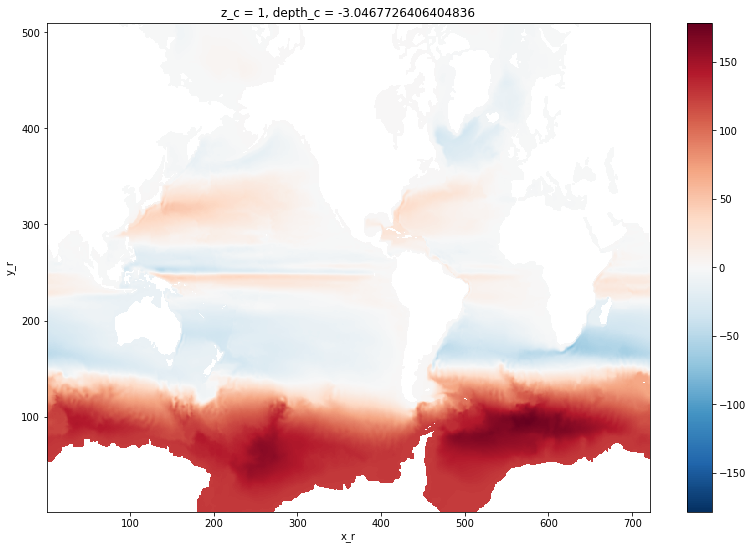

In [10]:
psi.mean("t").plot(size=9);

## Calculate speed

In [11]:
from xorca.calc import calculate_speed

In [12]:
calculate_speed??

Signature: calculate_speed(ds)
Source:   
def calculate_speed(ds):
    grid = xgcm.Grid(ds, periodic=["Y", "X"])

    U_cc = grid.interp(ds.vozocrtx, "X", to="center")
    V_cc = grid.interp(ds.vomecrty, "Y", to="center")

    speed = (U_cc**2 + V_cc**2)**0.5

    return speed
File:      ~/work/xorca/xorca/calc.py
Type:      function


In [13]:
speed = calculate_speed(ds)
speed = speed.where(ds.tmask == 1.0)
speed

<xarray.DataArray (t: 12, z_c: 46, y_c: 509, x_c: 720)>
dask.array<shape=(12, 46, 509, 720), dtype=float32, chunksize=(1, 46, 1, 1)>
Coordinates:
  * t        (t) datetime64[ns] 2009-01-16T12:00:00 2009-02-15 ...
  * z_c      (z_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * y_c      (y_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * x_c      (x_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    llon_cc  (y_c, x_c) float32 dask.array<shape=(509, 720), chunksize=(509, 720)>
    depth_c  (z_c) float64 dask.array<shape=(46,), chunksize=(46,)>
    llat_cc  (y_c, x_c) float32 dask.array<shape=(509, 720), chunksize=(509, 720)>

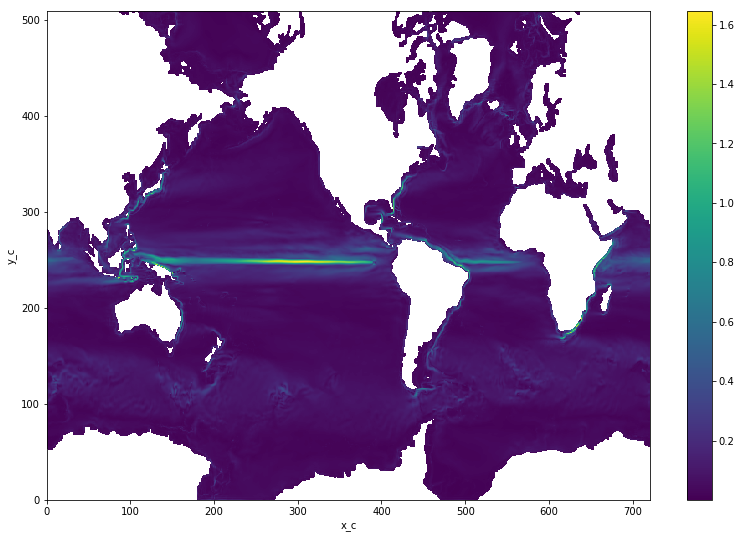

In [14]:
speed.mean("t").max("z_c").plot(size=9);

## Calcuate the AMOC

In [15]:
from xorca.calc import calculate_moc

amoc = calculate_moc(ds, region="atl")
amoc

<xarray.DataArray 'mocatl' (y_r: 509, z_l: 46, t: 12)>
dask.array<shape=(509, 46, 12), dtype=float64, chunksize=(509, 1, 1)>
Coordinates:
  * y_r         (y_r) float64 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
  * z_l         (z_l) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 ...
  * t           (t) datetime64[ns] 2009-01-16T12:00:00 2009-02-15 ...
    lat_mocatl  (y_r) float64 dask.array<shape=(509,), chunksize=(509,)>
    depth_l     (z_l) float64 dask.array<shape=(46,), chunksize=(46,)>

### Plotting with proper coordinates

Note that in the North, the latitutde not necessarily increases monotonically.  To fix this, we first sort the `amoc_mean` and `amoc_std` by their latitude coordinates.  We also restrict to everything North of 35°N and we mask.

In [16]:
amoc = amoc.sortby("lat_mocatl")
amoc = amoc.where(amoc["lat_mocatl"] > -35.0, drop=True)
amoc = amoc.where(amoc != 0.0)

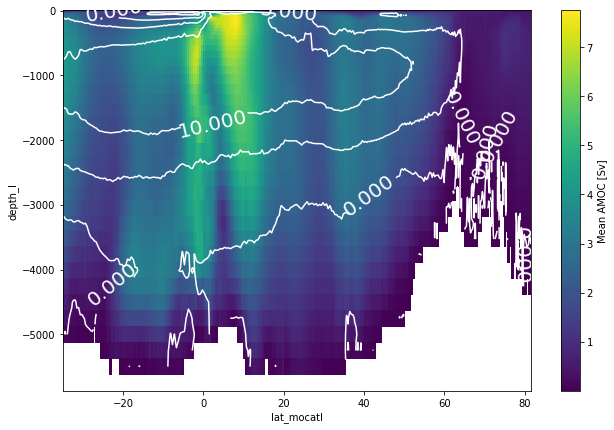

In [17]:
amoc_mean = amoc.mean("t").rename("Std dev of AMOC [Sv]")

amoc_std = amoc.std("t").rename("Mean AMOC [Sv]")

amoc_std.plot.pcolormesh("lat_mocatl", "depth_l", size=7);

cs = amoc_mean.plot.contour("lat_mocatl", "depth_l", colors='white');
plt.clabel(cs, fontsize=20, inline=1);